## Simulations

## Hide or show code

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle on/off the raw code."></form>''')

## Import packages

In [2]:
import numpy as np
import pandas as pd
from random import random
import pickle as pc

import matplotlib.pyplot as mp
import matplotlib.lines as mlines
from matplotlib import rc
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)
mp.rcParams['figure.figsize'] = (4, 4)

## Define simulation algorithms

In [3]:
## Gillespie algorithm: logistic

def gillespie_logistic():

    # initial condition
    
    t = 0
    
    n = np.copy(n0)
    
    # samples
    
    timeseries = np.zeros((t_points, n_types), dtype = int)
    
    # initial state
    
    timeseries[0, :] = n
    
    sample_index = 1
        
    while t <= t_simulated:
    
        # Transition rates
    
        T_up = (gR * n + mR) * (N - n.sum()) / N
    
        T_down = dR * n / N
        
        T_up_n_down = np.hstack((T_up, T_down))
        
        # Time to sample and propensities
        
        time_par = 1. / T_up_n_down.sum()
        
        choice_par = T_up_n_down * time_par
        
        t_sampled = np.random.exponential(time_par)
            
        q = random()
        
        p_sum = 0
        
        i = 0
        
        while p_sum + choice_par[i] < q:
            
            p_sum += choice_par[i]
            
            i += 1
            
        # sampling
            
        while sample_index < t_points and sampling_times[sample_index] < t + t_sampled:
            
            timeseries[sample_index] = n
                        
            sample_index += 1 
            
        # modify current state
            
        if i < n_types:
            
            n[i] += 1
            
        else:
            
            n[i - n_types] -= 1
            
        t += t_sampled
            
    return timeseries

In [4]:
## Gillespie algorithm: Lotka-Volterra

def gillespie_LV():

    # initial condition
    
    t = 0
    
    n = np.copy(n0)
    
    # samples
    
    timeseries = np.zeros((t_points, n_types), dtype = int)
    
    # initial state
    
    timeseries[0, :] = n
    
    sample_index = 1
        
    while t <= t_simulated:
        
        # Transition rates
    
        T_up = (gR + np.dot(I_p, n)) * n
    
        T_down = np.dot(I_n, n) * n
        
        T_up_n_down = np.hstack((T_up, T_down))
        
        # Time to sample and propensities
        
        time_par = 1. / T_up_n_down.sum()
        
        choice_par = T_up_n_down * time_par
        
        t_sampled = np.random.exponential(time_par)
            
        q = random()
        
        p_sum = 0
        
        i = 0
        
        while p_sum + choice_par[i] < q:
            
            p_sum += choice_par[i]
            
            i += 1
            
        # sampling
            
        while sample_index < t_points and sampling_times[sample_index] < t + t_sampled:
            
            timeseries[sample_index] = n
                        
            sample_index += 1 
            
        # modify current state
            
        if i < n_types:
            
            n[i] += 1
            
        else:
            
            n[i - n_types] -= 1
            
        t += t_sampled
            
    return timeseries

## Define function to compute moments from data

In [5]:
## Generate data (absolute and relative abundance)

def compute_moments(model):

    if model == 'logistic':
        gillespie = gillespie_logistic()

    elif model == 'lotka-volterra':
        gillespie = gillespie_LV()

    # Datasets to store moments
        
    abs_abund_timeseries_df = []

    rel_abund_timeseries_df = []

    # Make Gillespie simulations
    
    for sample in range(n_timeseries):

        # Absolute abundance
        
        abs_abund_timeseries = pd.DataFrame(data = gillespie, index=['t_%i'%i for i in range(t_points)], columns=['type_%i'%i for i in range(n_types)])

        abs_abund_timeseries_df.append(abs_abund_timeseries)
        
        # Relative abundance

        rel_abund_timeseries = abs_abund_timeseries.div(abs_abund_timeseries.sum(axis=1), axis=0)

        rel_abund_timeseries_df.append(rel_abund_timeseries)

    # First moment for each type as a vector

    m_k_abs_abund = sum(abs_abund_timeseries_df) / n_timeseries

    m_k_rel_abund = sum(rel_abund_timeseries_df) / n_timeseries

    # Co-moment for types k and j as a matrix

    cm_kj_abs_abund = np.zeros((t_points, n_types, n_types))

    cm_kj_rel_abund = np.zeros((t_points, n_types, n_types))

    for t_point in range(t_points):

        for ts_index in range(n_timeseries):

            cm_kj_abs_abund[t_point,:,:] += np.outer(abs_abund_timeseries_df[ts_index].iloc[t_point,:], abs_abund_timeseries_df[ts_index].iloc[t_point,:])

            cm_kj_rel_abund[t_point,:,:] += np.outer(rel_abund_timeseries_df[ts_index].iloc[t_point,:], rel_abund_timeseries_df[ts_index].iloc[t_point,:])

    cm_kj_abs_abund /= n_timeseries

    cm_kj_rel_abund /= n_timeseries

    # Moments of scaling factor

    m_Sigma = np.zeros(t_points)

    for ts_index in range(n_timeseries):

        m_Sigma += abs_abund_timeseries_df[ts_index].sum(1)

    m_Sigma /= n_timeseries

    # Create an array of empirical moments (absolute abundance)
    
    data_abs_abund = np.zeros((t_points, n_types + n_types**2))
    data_abs_abund[:,:n_types] = m_k_abs_abund
    for t_point in range(t_points):
        data_abs_abund[t_point,n_types:] = cm_kj_abs_abund[t_point].reshape(1, n_types**2)[0]

    init_abs_abund = data_abs_abund[0,:]
    data_abs_abund = {"moments": data_abs_abund}

    # Create an array of empirical moments (relative abundance)

    data_rel_abund = np.zeros((t_points, n_types + n_types**2))
    data_rel_abund[:,:n_types] = m_k_rel_abund
    for t_point in range(t_points):
        data_rel_abund[t_point,n_types:] = cm_kj_rel_abund[t_point].reshape(1, n_types**2)[0]

    init_rel_abund = data_rel_abund[0,:]
    data_rel_abund = {"moments": data_rel_abund}
    
    return data_abs_abund, data_rel_abund, m_Sigma, init_abs_abund, init_rel_abund

## Logistic growth, immigration and death

Set parameters

In [6]:
# Number of microbial types
n_types = 3

# Carrying capacity
N = 1E5

# Growth rates
gR = np.array([0.5,0.8,1.4])

# Death rates
dR = np.array([1E2,1.3E2,1.6E2])

# Migration rates
mR = np.array([2E3,4E3,3E3])

# Initial populations
n0 = np.array([2800., 1400., 700.])

# Time to simulate
t_simulated = 5E0

# Number of sampling time points
t_points = 6

# Sampling time points
sampling_times = np.linspace(0, t_simulated, t_points)

# Number of time series
n_timeseries = 4

In [7]:
print(' growth rates: \n%s\n'%gR, 'death rates: \n%s\n'%dR, 'migration rates: \n%s\n'%mR, 'carrying capacity: \n%s\n'%N, 'initial pop.: \n%s'%n0)

 growth rates: 
[0.5 0.8 1.4]
 death rates: 
[100. 130. 160.]
 migration rates: 
[2000. 4000. 3000.]
 carrying capacity: 
100000.0
 initial pop.: 
[2800. 1400.  700.]


Simulate and compute moments

In [8]:
logistic_data_abs_abund, logistic_data_rel_abund, m_Sigma, init_abs_abund, init_rel_abund = compute_moments('logistic')

Define prior names

In [9]:
gR_names = ["gR_%i"%i for i in range(n_types)]
dR_names = ["dR_%i"%i for i in range(n_types)]
mR_names = ["mR_%i"%i for i in range(n_types)]
N_names = ["N"]
mSigma_names = ["mSigma[0]"]
parameter_names = gR_names + dR_names + mR_names + N_names + mSigma_names

true_par = list(gR) + list(dR) + list(mR) + [N] + [m_Sigma[0]]
true_par = dict(zip(parameter_names, true_par))

Save simulation parameters

In [10]:
# Upper threshold of numerical solution
upper_threshold = 3. * np.amax(logistic_data_abs_abund["moments"][:,:n_types],0)

with open('../data/logistic/simulation_parameters.pickle', 'wb') as f: 
    pc.dump({'n_types':n_types, 'N':N, 'gR':gR, 'dR':dR, 'mR':mR, 'mSigma':m_Sigma, 't_simulated':t_simulated, 't_points':t_points, 'sampling_times':sampling_times, 'n_timeseries':n_timeseries, 'init_abs_abund':init_abs_abund, 'init_rel_abund':init_rel_abund, 'true_par':true_par, 'upper_threshold':upper_threshold}, f)

Import equations for the numerical moments

In [11]:
from sc_logistic_numerics import model_abs_abund_closure_from_3rd as logistic_model_abs_abund
from sc_logistic_numerics import model_rel_abund_closure_from_3rd as logistic_model_rel_abund

logistic_numerics_abs_abund = logistic_model_abs_abund(true_par)
logistic_numerics_rel_abund = logistic_model_rel_abund(true_par)

### Plotting of simulations and theory

Absolute abundance

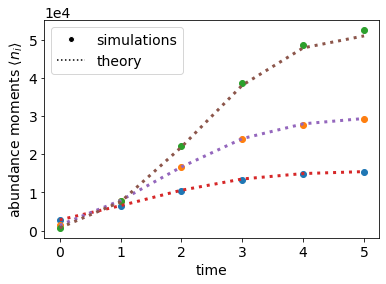

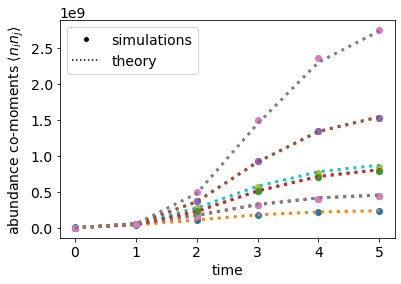

In [12]:
## Absolute abundance

logistic_data_m_k = logistic_data_abs_abund['moments'][:, :n_types]
logistic_data_cm_kj = logistic_data_abs_abund['moments'][:, n_types:]

logistic_numerics_m_k = logistic_numerics_abs_abund['moments'][:, :n_types]
logistic_numerics_cm_kj = logistic_numerics_abs_abund['moments'][:, n_types:]

# Plot moments

mp.plot(sampling_times, logistic_data_m_k, '.', markersize=12)
mp.plot(sampling_times, logistic_numerics_m_k, ':', linewidth=3)
# Annotate
mp.xlabel('time', fontsize=14)
mp.ylabel(r'abundance moments $\langle n_i \rangle$', fontsize=14)
marker_sim = mlines.Line2D([0], [0], label='simulations', color='w', marker='o', markerfacecolor='k')
line_theory_abs_abund = mlines.Line2D([0], [0], label='theory', color='k', linestyle=':')
mp.legend(handles=[marker_sim, line_theory_abs_abund], fontsize=14)
mp.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
mp.show();

# Plot co-moments

for k in range(n_types**2):
    mp.plot(sampling_times, logistic_data_cm_kj[:,k], '.', markersize=12)
    mp.plot(sampling_times, logistic_numerics_cm_kj[:,k], ':', linewidth=3)
# Annotate
mp.xlabel('time', fontsize=14)
mp.ylabel(r'abundance co-moments $\langle n_i n_j \rangle$', fontsize=14)
marker_sim = mlines.Line2D([0], [0], label='simulations', color='w', marker='o', markerfacecolor='k')
line_theory_abs_abund = mlines.Line2D([0], [0], label='theory', color='k', linestyle=':')
mp.legend(handles=[marker_sim, line_theory_abs_abund], fontsize=14)
mp.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
mp.show();

Relative abundance

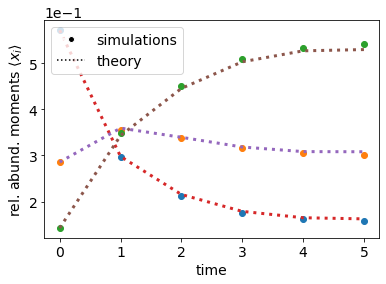

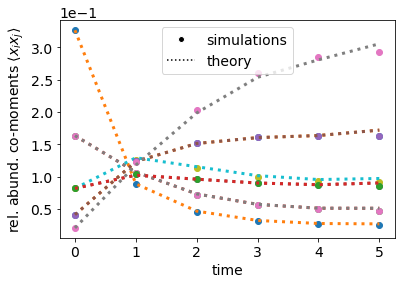

In [13]:
## Relative abundance

logistic_data_m_k = logistic_data_rel_abund['moments'][:, :n_types]
logistic_data_cm_kj = logistic_data_rel_abund['moments'][:, n_types:]

logistic_numerics_m_k = logistic_numerics_rel_abund['moments'][:, :n_types]
logistic_numerics_cm_kj = logistic_numerics_rel_abund['moments'][:, n_types:-1]

# Plot moments

mp.plot(sampling_times, logistic_data_m_k, '.', markersize=12)
mp.plot(sampling_times, logistic_numerics_m_k, ':', linewidth=3)
# Annotate
mp.xlabel('time', fontsize=14)
mp.ylabel(r'rel. abund. moments $\langle x_i \rangle$', fontsize=14)
marker_sim = mlines.Line2D([0], [0], label='simulations', color='w', marker='o', markerfacecolor='k')
line_theory_abs_abund = mlines.Line2D([0], [0], label='theory', color='k', linestyle=':')
mp.legend(handles=[marker_sim, line_theory_abs_abund], fontsize=14)
mp.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
mp.show();

# Plot co-moments

for k in range(n_types**2):
    mp.plot(sampling_times, logistic_data_cm_kj[:,k], '.', markersize=12)
    mp.plot(sampling_times, logistic_numerics_cm_kj[:,k], ':', linewidth=3)
# Annotate
mp.xlabel('time', fontsize=14)
mp.ylabel(r'rel. abund. co-moments $\langle x_i x_j \rangle$', fontsize=14)
marker_sim = mlines.Line2D([0], [0], label='simulations', color='w', marker='o', markerfacecolor='k')
line_theory_abs_abund = mlines.Line2D([0], [0], label='theory', color='k', linestyle=':')
mp.legend(handles=[marker_sim, line_theory_abs_abund], fontsize=14)
mp.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
mp.show();

Save results

In [14]:
with open('../data/logistic/simulation_abs_abund.pickle', 'wb') as f: 
    pc.dump({'data': logistic_data_abs_abund, 'numerics': logistic_numerics_abs_abund}, f)
    
with open('../data/logistic/simulation_rel_abund.pickle', 'wb') as f: 
    pc.dump({'data': logistic_data_rel_abund, 'm_Sigma': m_Sigma, 'numerics': logistic_numerics_rel_abund}, f)

## Lotka-Volterra

Set parameters

In [15]:
# Number of microbial types
n_types = 3

# Growth rates
gR = np.array([0.9, 1.7, 1.3])

# Interaction rates matrix (_p positive, _n negative)
I = 1E-5 * np.array(([-4.8, 2.7, -5.], [-2.9, -6.3, 3.3], [2., -4.1, -5.4]))
I_p = np.zeros((n_types, n_types))
I_n = np.zeros((n_types, n_types))
I_p[I>0] = abs(I[I>0])
I_n[I<0] = abs(I[I<0])

# Initial populations
n0 = np.array([700, 7000, 12000])

# Time simulated
t_simulated = 5E0

# Number of sampling time points
t_points = 6

# Sampling time points
sampling_times = np.linspace(0, t_simulated, t_points)

# Number of time series
n_timeseries = 4

In [16]:
print(' growth rates: \n%s\n'%gR, 'interaction rates: \n%s\n'%I, 'initial pop.: \n%s'%n0)

 growth rates: 
[0.9 1.7 1.3]
 interaction rates: 
[[-4.8e-05  2.7e-05 -5.0e-05]
 [-2.9e-05 -6.3e-05  3.3e-05]
 [ 2.0e-05 -4.1e-05 -5.4e-05]]
 initial pop.: 
[  700  7000 12000]


Simulate and compute moments

In [17]:
LV_data_abs_abund, LV_data_rel_abund, m_Sigma, init_abs_abund, init_rel_abund = compute_moments('lotka-volterra')

Define prior names

In [18]:
gR_names = ["gR_%i"%i for i in range(n_types)]
I_names = ["I_%i_%i"%(i,j) for i in range(n_types) for j in range(n_types)]
mSigma_names = ["mSigma[0]"]
parameter_names = gR_names + I_names + mSigma_names

true_par = list(gR) + list(I.reshape(1,n_types**2)[0]) + [m_Sigma[0]]
true_par = dict(zip(parameter_names, true_par))

Save simulation parameters

In [19]:
# Upper threshold of numerical solution
upper_threshold = 3. * np.amax(LV_data_abs_abund["moments"][:,:n_types],0)

with open('../data/LV/simulation_parameters.pickle', 'wb') as f: 
    pc.dump({'n_types':n_types, 'gR':gR, 'I':I, 'mSigma':m_Sigma, 't_simulated':t_simulated, 't_points':t_points, 'sampling_times':sampling_times, 'n_timeseries':n_timeseries, 'init_abs_abund':init_abs_abund, 'init_rel_abund':init_rel_abund, 'true_par':true_par, 'upper_threshold':upper_threshold}, f)

Import equations for the numerical moments

In [20]:
from sc_LV_numerics import model_abs_abund_closure_from_3rd as LV_model_abs_abund
from sc_LV_numerics import model_rel_abund_closure_from_3rd as LV_model_rel_abund

LV_numerics_abs_abund = LV_model_abs_abund(true_par)
LV_numerics_rel_abund = LV_model_rel_abund(true_par)

### Plotting of simulations and theory

Absolute abundance

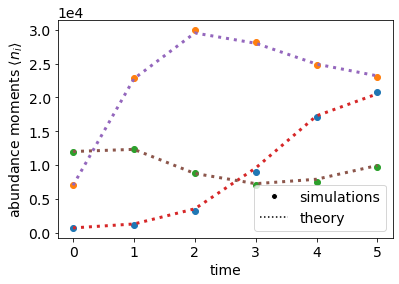

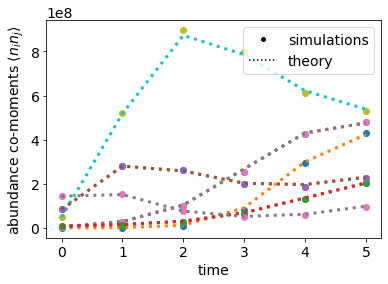

In [21]:
# Simulate timeseries using meanfield equations

LV_data_m_k = LV_data_abs_abund['moments'][:, :n_types]
LV_data_cm_kj = LV_data_abs_abund['moments'][:, n_types:]

LV_numerics_m_k = LV_numerics_abs_abund['moments'][:, :n_types]
LV_numerics_cm_kj = LV_numerics_abs_abund['moments'][:, n_types:]

# Plot moments

mp.plot(sampling_times, LV_data_m_k, '.', markersize=12)
mp.plot(sampling_times, LV_numerics_m_k, ':', linewidth=3)
# Annotate
mp.xlabel('time', fontsize=14)
mp.ylabel(r'abundance moments $\langle n_i \rangle$', fontsize=14)
marker_sim = mlines.Line2D([0], [0], label='simulations', color='w', marker='o', markerfacecolor='k')
line_theory_abs_abund = mlines.Line2D([0], [0], label='theory', color='k', linestyle=':')
mp.legend(handles=[marker_sim, line_theory_abs_abund], fontsize=14)
mp.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
mp.show();

# Plot co-moments

for k in range(n_types**2):
    mp.plot(sampling_times, LV_data_cm_kj[:,k], '.', markersize=12)
    mp.plot(sampling_times, LV_numerics_cm_kj[:,k], ':', linewidth=3)
# Annotate
mp.xlabel('time', fontsize=14)
mp.ylabel(r'abundance co-moments $\langle n_i n_j \rangle$', fontsize=14)
marker_sim = mlines.Line2D([0], [0], label='simulations', color='w', marker='o', markerfacecolor='k')
line_theory_abs_abund = mlines.Line2D([0], [0], label='theory', color='k', linestyle=':')
mp.legend(handles=[marker_sim, line_theory_abs_abund], fontsize=14)
mp.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
mp.show();

Relative abundance

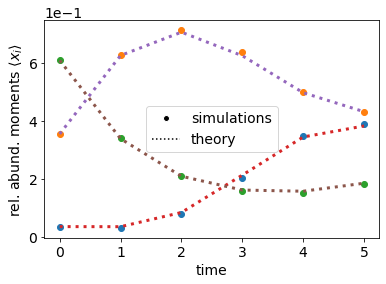

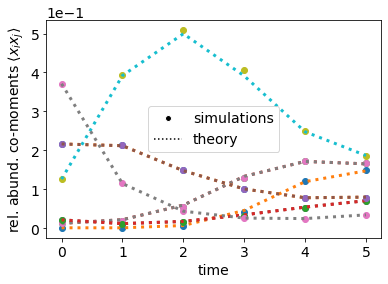

In [22]:
# Relative abundance

LV_data_m_k = LV_data_rel_abund['moments'][:, :n_types]
LV_data_cm_kj = LV_data_rel_abund['moments'][:, n_types:]

LV_numerics_m_k = LV_numerics_rel_abund['moments'][:, :n_types]
LV_numerics_cm_kj = LV_numerics_rel_abund['moments'][:, n_types:-1]

# Plot moments

mp.plot(sampling_times, LV_data_m_k, '.', markersize=12)
mp.plot(sampling_times, LV_numerics_m_k, ':', linewidth=3)
# Annotate
mp.xlabel('time', fontsize=14)
mp.ylabel(r'rel. abund. moments $\langle x_i \rangle$', fontsize=14)
marker_sim = mlines.Line2D([0], [0], label='simulations', color='w', marker='o', markerfacecolor='k')
line_theory_abs_abund = mlines.Line2D([0], [0], label='theory', color='k', linestyle=':')
mp.legend(handles=[marker_sim, line_theory_abs_abund], fontsize=14)
mp.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
mp.show();

# Plot co-moments

for k in range(n_types**2):
    mp.plot(sampling_times, LV_data_cm_kj[:,k], '.', markersize=12)
    mp.plot(sampling_times, LV_numerics_cm_kj[:,k], ':', linewidth=3)
# Annotate
mp.xlabel('time', fontsize=14)
mp.ylabel(r'rel. abund. co-moments $\langle x_i x_j \rangle$', fontsize=14)
marker_sim = mlines.Line2D([0], [0], label='simulations', color='w', marker='o', markerfacecolor='k')
line_theory_abs_abund = mlines.Line2D([0], [0], label='theory', color='k', linestyle=':')
mp.legend(handles=[marker_sim, line_theory_abs_abund], fontsize=14)
mp.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
mp.show();

Save results

In [23]:
with open('../data/LV/simulation_abs_abund.pickle', 'wb') as f: 
    pc.dump({'data': LV_data_abs_abund, 'numerics': LV_numerics_abs_abund}, f)
    
with open('../data/LV/simulation_rel_abund.pickle', 'wb') as f: 
    pc.dump({'data': LV_data_rel_abund, 'm_Sigma': m_Sigma, 'numerics': LV_numerics_rel_abund}, f)